In [1]:
import matplotlib
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
from theano import tensor as tt, function, scan, shared

from rl.agent import Agent, AgentVars
from rl.task import Task, TaskVars
from rl.interaction import agent_task_interaction
from rl.plots import plot_data
from rl.plot_utils import set_mpl_defaults

set_mpl_defaults(matplotlib)
theano.config.compute_test_value = 'off' # Use 'warn' to activate this feature

import warnings
warnings.filterwarnings("ignore")

/Users/felixmolter/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Simulate data

In [2]:
# Agent setup
agent_vars = AgentVars()
agent_vars.alpha_win = 0.5
agent_vars.alpha_loss = 0.2
agent_vars.beta = 5
agent = Agent(agent_vars)
agent

Dual learning rate agent with
  alpha_win = 0.5
  alpha_loss = 0.2
  beta = 5

In [3]:
# Task setup
task_vars = TaskVars()
task_vars.n_trials = 200
task_vars.n_blocks = 1
task = Task(task_vars)
task

Task with the task rules:
  {'0': {'p_r_0': 0.2, 'p_r_1': 0.8, 'a_correct': [1]}, '1': {'p_r_0': 0.8, 'p_r_1': 0.2, 'a_correct': [0]}}

In [4]:
# Let the agent perform the task
df = agent_task_interaction(task, agent)
df.head()

,trial,block,rule,p_r_0,p_r_1,r,a,corr,p_a0,p_a1,v_a_0,v_a_1,ll
0,0.0,0.0,0.0,0.2,0.8,1.0,1.0,1.0,0.500000,0.500000,0.0,0.50000,-0.693147
1,1.0,0.0,0.0,0.2,0.8,1.0,1.0,1.0,0.075858,0.924142,0.0,0.75000,-0.078890
2,2.0,0.0,0.0,0.2,0.8,1.0,1.0,1.0,0.022977,0.977023,0.0,0.87500,-0.023245
3,3.0,0.0,0.0,0.2,0.8,1.0,1.0,1.0,0.012432,0.987568,0.0,0.93750,-0.012510
4,4.0,0.0,0.0,0.2,0.8,1.0,1.0,1.0,0.009126,0.990874,0.0,0.96875,-0.009168


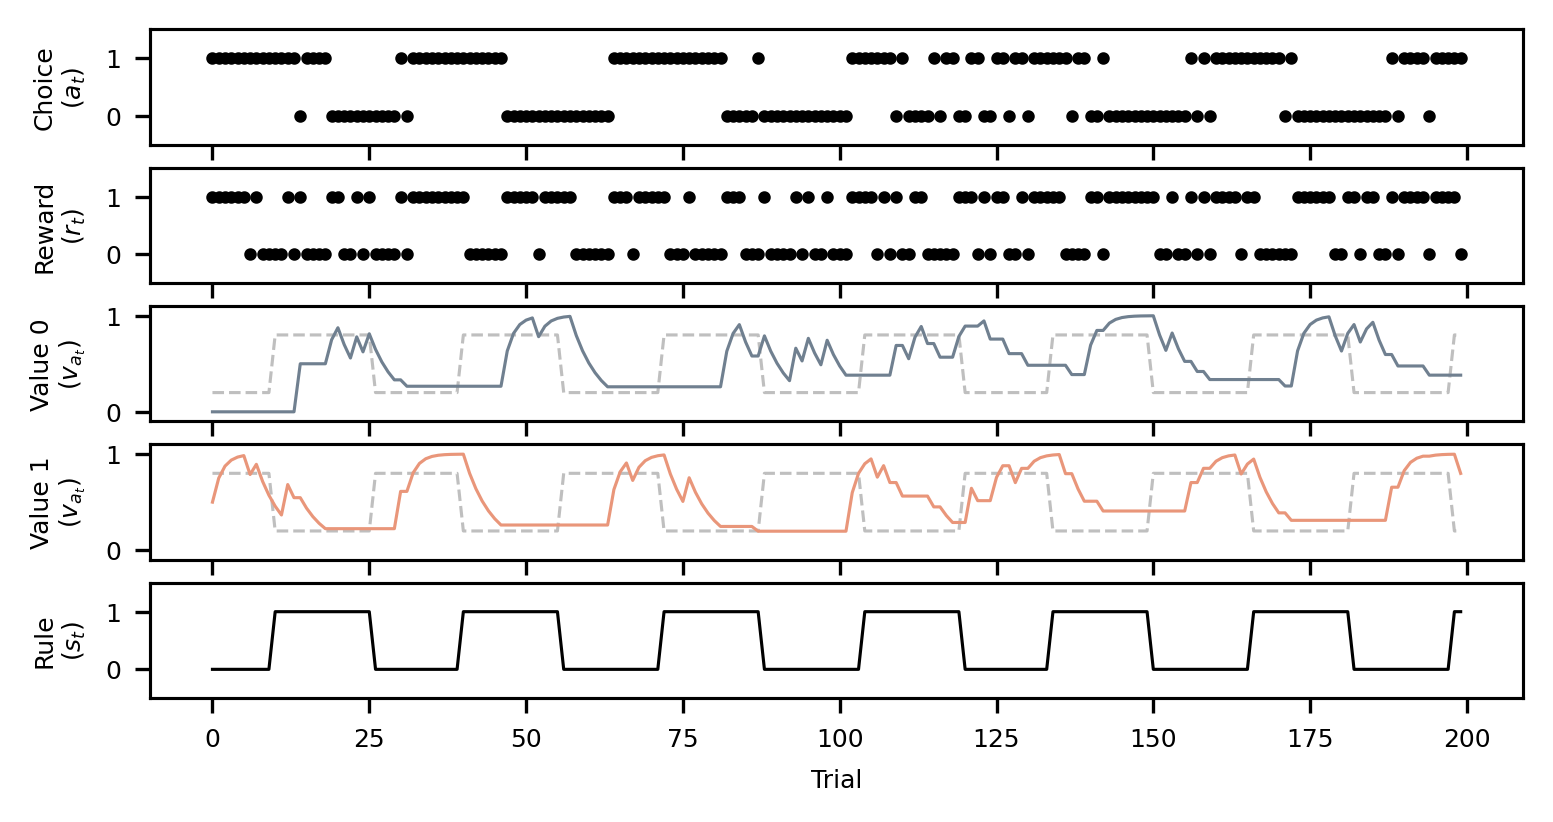

In [5]:
plot_data(df);

# PyMC3 implementation

## Learning functions

In [6]:
# Simple Rescorla Wagner model functions, with one single learning rate
# We actually do not use these below.

def RW_learn(r_t, a_t, v_t, alpha):
    """Simple RW learning rule.
    
    Args:
        r_t (float): current reward
        a_t (int): current action
        v_t (numpy.array): current values
        alpha (float): learning rate
    """
    # arg order in scan is: sequences (if any), prior result(s) (if needed), non-sequences (if any)
    delta = r_t - v_t[a_t]
    v_a_tplus1 = v_t[a_t] + alpha * delta
    v_tplus1 = tt.set_subtensor(v_t[a_t], v_a_tplus1)
    return v_tplus1

def tt_RW_compute_vs(r, a, alpha, v0):
    """Theano tensor implementation of the RW model's learning over all trials.
    
    Args:
        r (1d tensor): rewards
        a (1d tensor): actions
        alpha (float): learning rate
        v0 (1d tensor): initial valuation

    Returns:
        2d tensor: matrix of valuations (n_trials x n_options)
    """
    v_new, update = scan(
        lambda r, a, v, alpha: RW_lean(r, a, v, alpha),
        sequences=[r, a],
        non_sequences=[alpha],
        outputs_info=[v0])
    return v_new

In [7]:
# Rescorla Wagner Win Loss (RWwl) functions.
# The first function implements a single learning step
# The second function implements learning over all trials, for a given set of parameters and data.

def RWwl_learn(r_t, a_t, v_t, alpha_win, alpha_loss):
    """RW learning rule with two learning rates:
        alpha_win:  Following positive rewards (r=1)
        alpha_loss: Following negative rewards (r=0)
    The model is described in Kahnt, Park et al. (2008)
    
    Args:
        r_t (float): current reward
        a_t (int): current action
        v_t (numpy.array): current values
        alpha_win (float): learning rate for positive rewards
        alpha_loss (float): learning rate for negative rewards
    """
    # arg order in scan is: sequences (if any), prior result(s) (if needed), non-sequences (if any)
    delta = r_t - v_t[a_t]
    alpha = tt.switch(tt.lt(delta, 0), alpha_loss, alpha_win)
    v_a_tplus1 = v_t[a_t] + alpha * delta
    v_tplus1 = tt.set_subtensor(v_t[a_t], v_a_tplus1)
    return v_tplus1

def tt_RWwl_compute_vs(r, a, alpha_win, alpha_loss, v0):
    """Theano tensor implementation of the RW model's learning over all trials.
    
    Args:
        r (1d tensor): rewards
        a (1d tensor): actions
        alpha_win (float): learning rate for wins
        alpha_loss (float): learning rate for losses
        v0 (1d tensor): initial valuation

    Returns:
        2d tensor: matrix of valuations (n_trials x n_options)
    """
    v_new, update = scan(
        lambda r, a, v, alpha_win, alpha_loss: RWwl_learn(r, a, v, alpha_win, alpha_loss),
        sequences=[r, a],
        non_sequences=[alpha_win, alpha_loss],
        outputs_info=[v0])
    return v_new

In [8]:
# Compile the function to see if it works

v0 = tt.dvector('v0')
v = tt.dvector('v')
a = tt.ivector('a')
r = tt.dvector('r')
alpha_win = tt.dscalar('alpha_win')
alpha_loss = tt.dscalar('alpha_loss')

v_new = tt_RWwl_compute_vs(r, a, alpha_win, alpha_loss, v0)

RWwl_compute_vs = function([r, a, alpha_win, alpha_loss, v0], v_new)

In [9]:
r = df['r']
a = df['a'].values.astype(np.int32)
alpha_win = 0.2
alpha_loss = 0.1
v0 = np.full(2, 0.1)

vs_pred = RWwl_compute_vs(r, a, alpha_win, alpha_loss, v0)
vs_pred[:10, :]

array([[0.1       , 0.28      ],
       [0.1       , 0.424     ],
       [0.1       , 0.5392    ],
       [0.1       , 0.63136   ],
       [0.1       , 0.705088  ],
       [0.1       , 0.7640704 ],
       [0.1       , 0.68766336],
       [0.1       , 0.75013069],
       [0.1       , 0.67511762],
       [0.1       , 0.60760586]])

## Full PyMC3 model

In [11]:
# Data
n_options = 2
r = shared(df['r'].values)
a = shared(df['a'].values.astype(np.int32))

In [12]:
with pm.Model() as RWwl:
    
    # Priors
    alpha_win = pm.Uniform("alpha_win", 0, 1)     # Learning rate for wins
    alpha_loss = pm.Uniform("alpha_loss", 0, 1)     # Learning rate for losses
    beta  = pm.Gamma("beta", 0.01, 0.01)  # Inverse temperature
    v0    = tt.zeros(n_options)           # Initial valuation, could be estimated, too, but we fix it here for simplicity
    
    # Likelihood
    v   = tt_RWwl_compute_vs(r, a, alpha_win, alpha_loss, v0)   # Valuation
    cp  = tt.nnet.softmax(beta * v)          # Choice probabilities
    obs = pm.Categorical("obs", p=cp, observed=a)  # Observed choices


# Parameter estimation

## MCMC

In [14]:
with RWwl:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha_loss, alpha_win]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 151 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [15]:
print(pm.summary(trace, hdi_prob=0.95))

              mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
alpha_win    0.624   0.159     0.338      0.931      0.006    0.005     666.0   
alpha_loss   0.075   0.040     0.007      0.149      0.001    0.001     761.0   
beta        14.306  10.619     4.719     32.524      0.515    0.365     424.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
alpha_win    606.0     637.0     604.0   1.01  
alpha_loss   761.0     613.0     543.0   1.01  
beta         424.0     617.0     536.0   1.00  


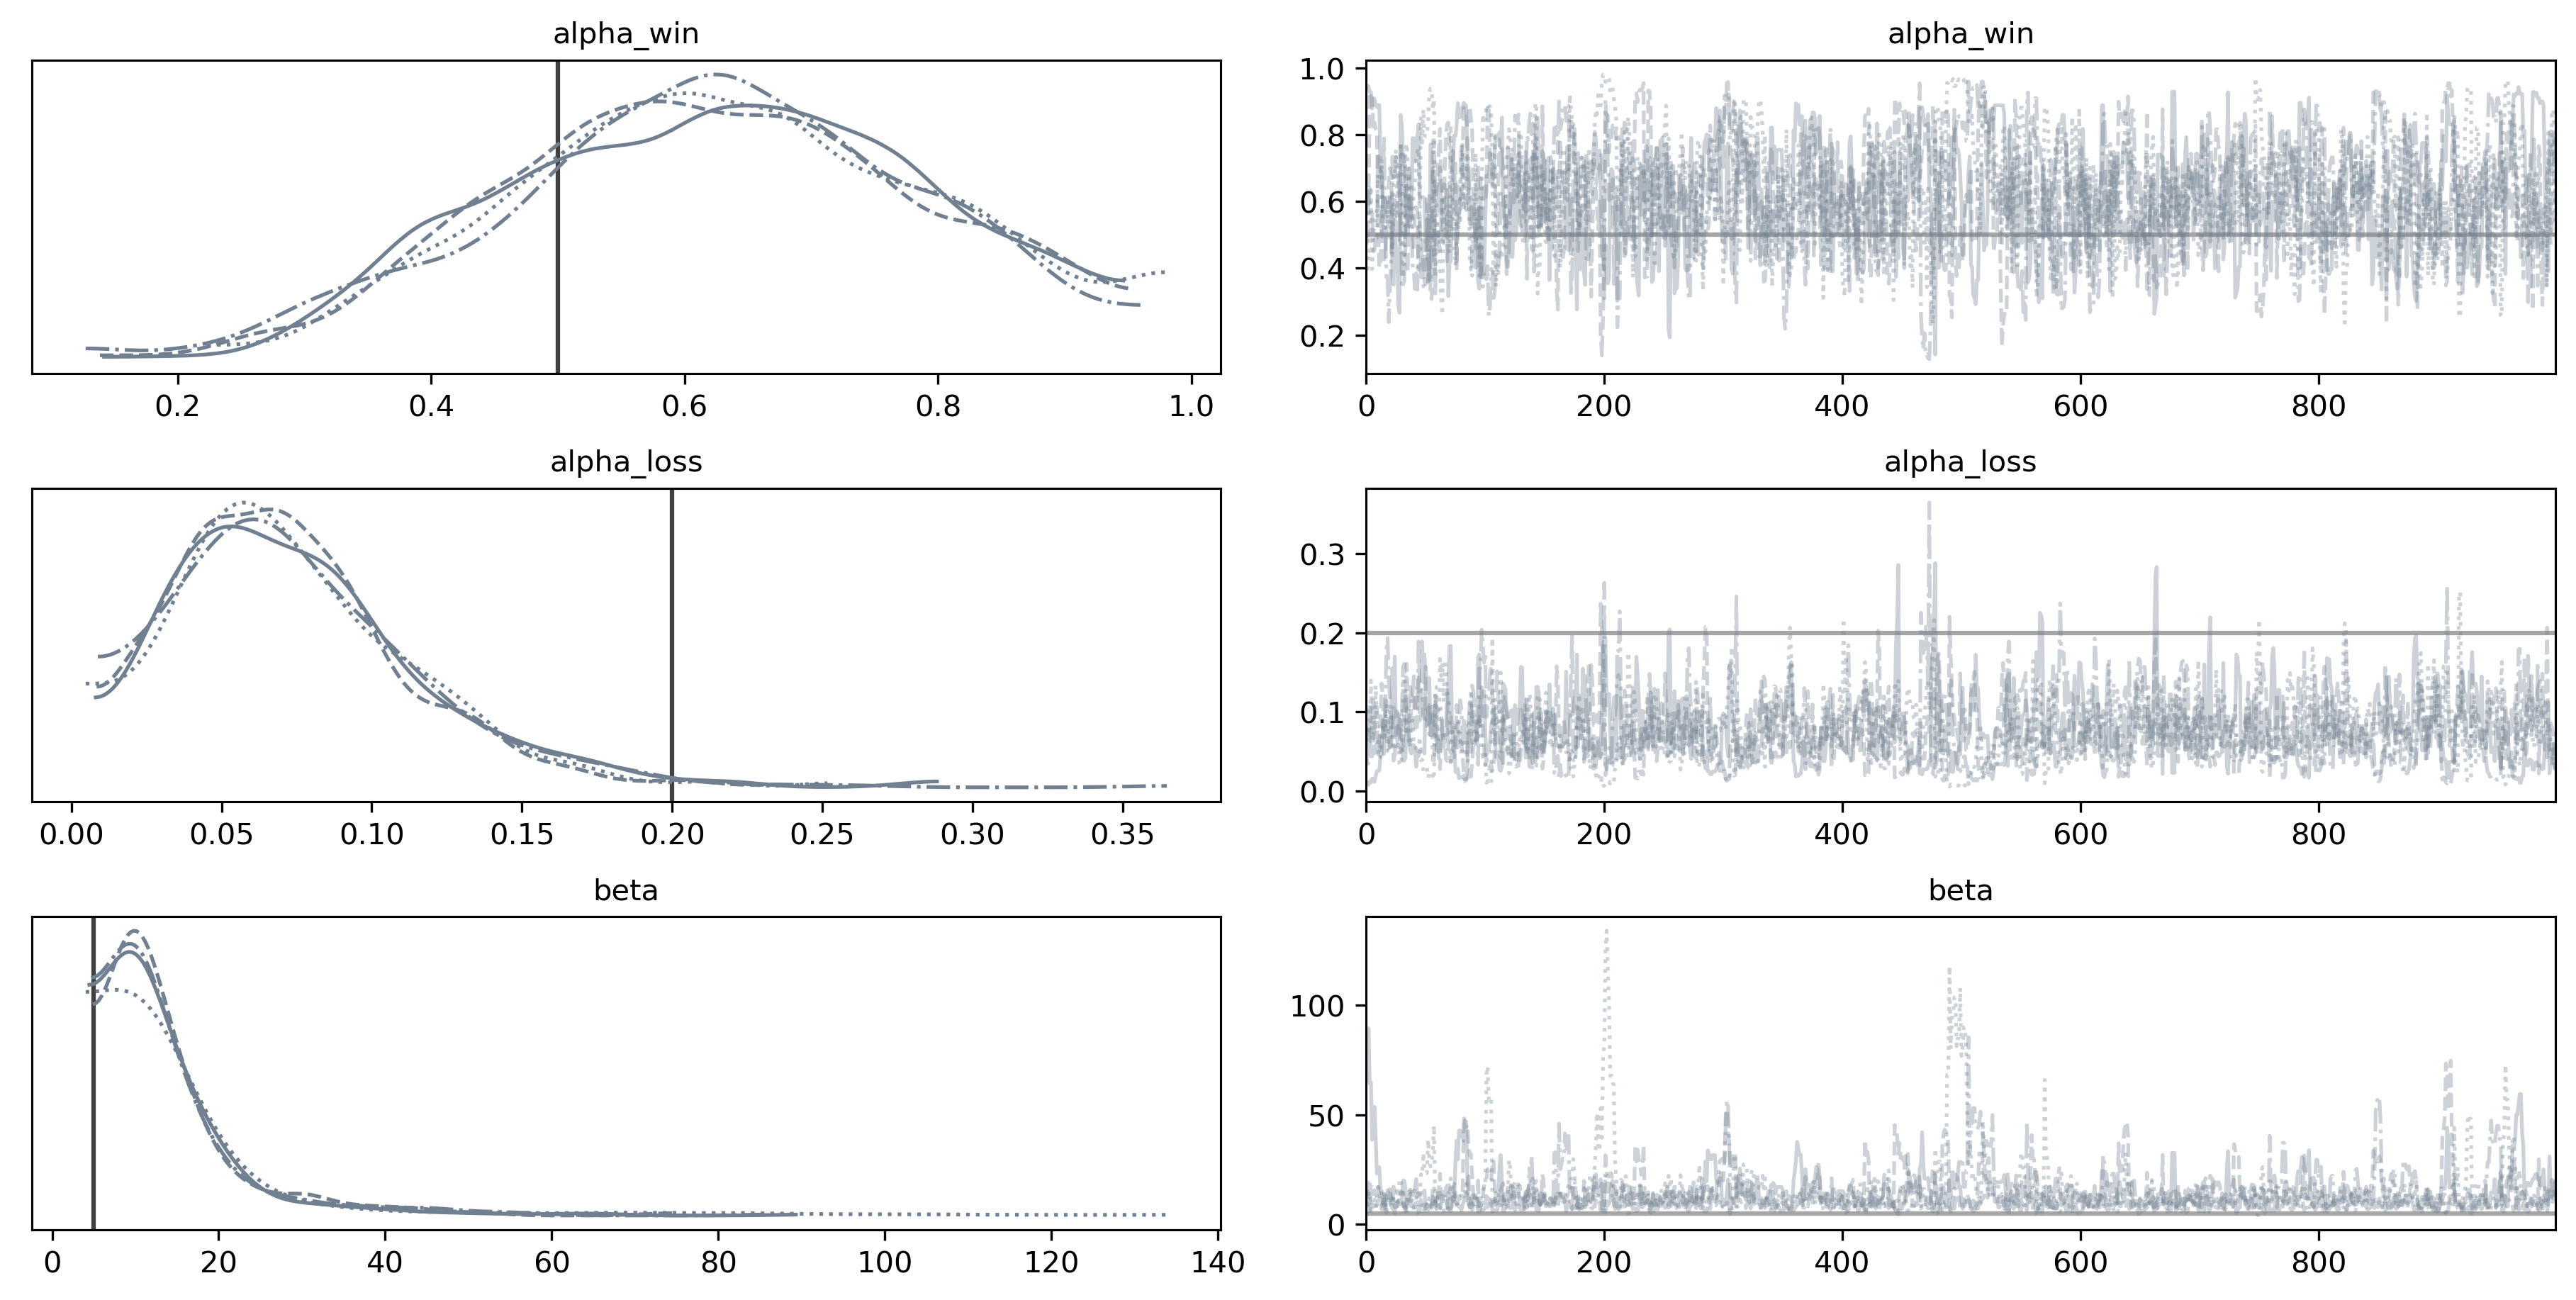

In [16]:
pm.traceplot(trace,
             lines=[('alpha_win', {}, [agent.agent_vars.alpha_win]),
                    ('alpha_loss', {}, [agent.agent_vars.alpha_loss]),
                    ('beta', {}, [agent.agent_vars.beta])]);

## Variational Inference

In [17]:
with RWwl:
    mean_field = pm.fit()

Finished [100%]: Average Loss = 76.16


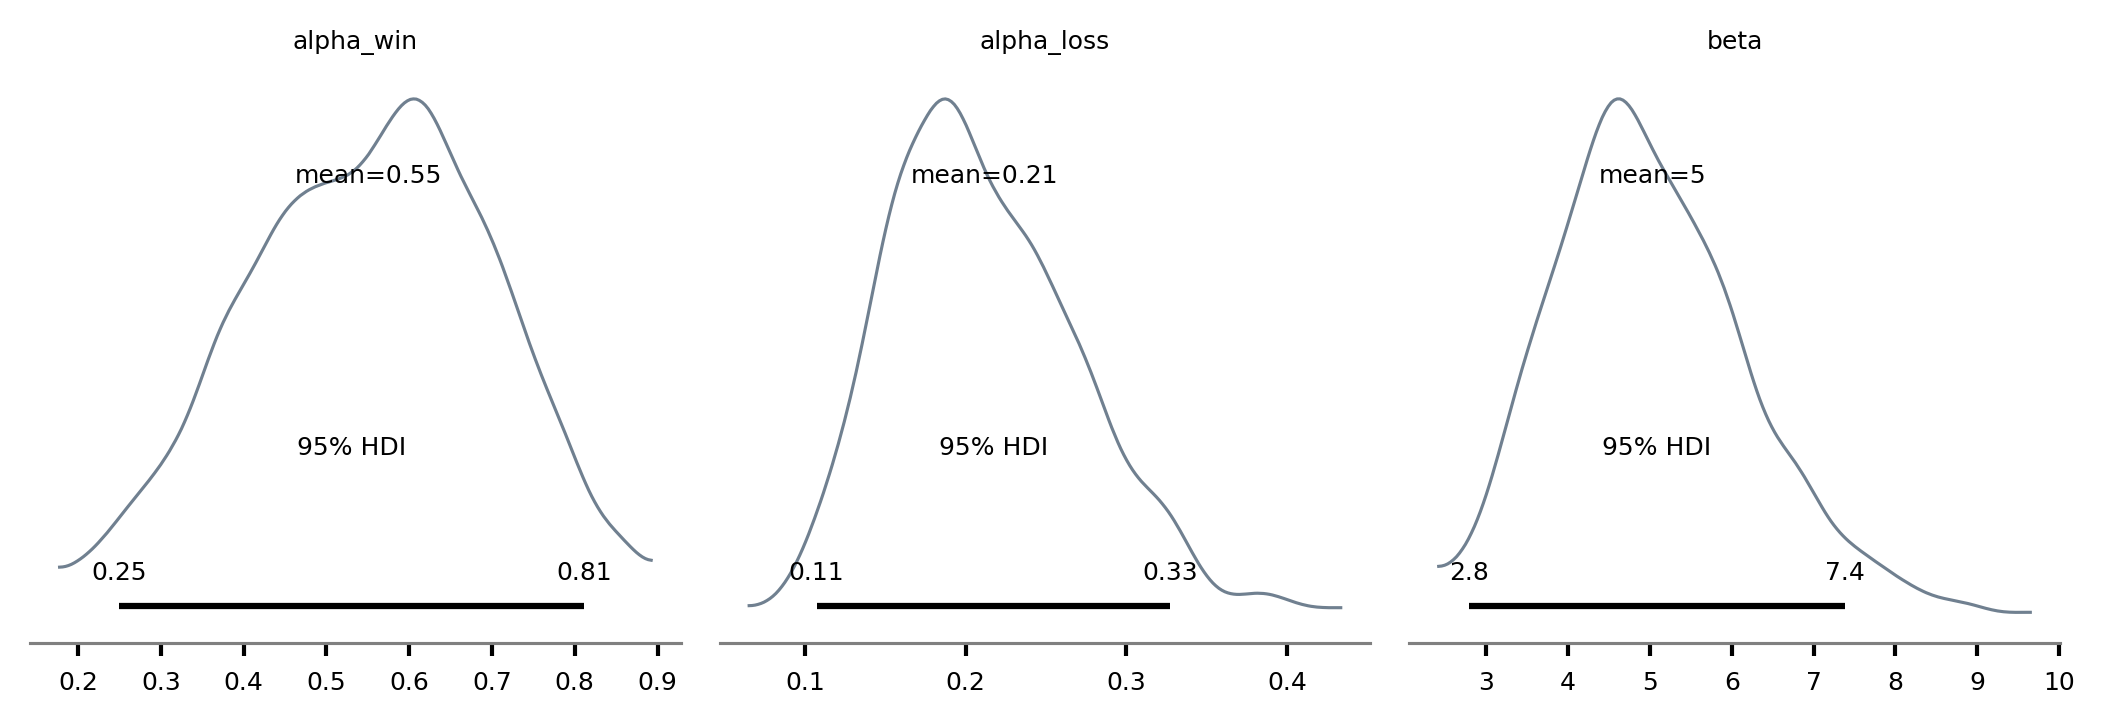

In [22]:
pm.plot_posterior(mean_field.sample(1000),
                  color="slategray",
                  hdi_prob=0.95);

In [19]:
agent

Dual learning rate agent with
  alpha_win = 0.5
  alpha_loss = 0.2
  beta = 5

# Conclusion

Our implemented Bayesian parameter estimation procedures generally seem to work. Variational Inference produced estimates closer to the true ones.